# Import Statements

In [38]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# carry out one hot encoding
from feature_engine.encoding import OneHotEncoder

# Import Scalers
# for min-max scaling
from sklearn.preprocessing import MinMaxScaler
# for standardization
from sklearn.preprocessing import StandardScaler
# for robust scaling
from sklearn.preprocessing import RobustScaler

# import XGBRegressor from xgboost package
from xgboost import XGBRegressor

# to evaluate model metrics
from sklearn.metrics import mean_squared_error, r2_score

# import grid search cv to improve decision tree model by helping search for parameters
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session

# to export model
import joblib

# Functions

In [39]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [40]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [41]:
# retrieve order details usa table from snowflake
order_data_from_snowflake = session.table("frostbyte_tasty_bytes.analytics.ORDER_DETAILS_USA_MATCHED")

In [42]:
# convert order_data_from_snowflake to pandas dataframe
order_df = order_data_from_snowflake.to_pandas()

In [43]:
# Get the total quantity sold for each menu item 
## group by 'MENU_ITEM_ID' and calculate the total quantity sold
total_qty_sold_per_item = order_df.groupby('MENU_ITEM_ID')['QUANTITY'].sum().reset_index()

## rename the 'QUANTITY' column to 'TOTAL_QTY_SOLD'
total_qty_sold_per_item = total_qty_sold_per_item.rename(columns={'QUANTITY': 'TOTAL_QTY_SOLD'})

# Menu Table 

In [44]:
# retrieve menu data from snowflake
menu_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.MENU")

In [45]:
# convert menu_data_from_snowflake to pandas dataframe
menu_df = menu_data_from_snowflake.to_pandas()

In [46]:
# merge total_qty_sold_per_item with final_product_df
menu_df = pd.merge(menu_df, total_qty_sold_per_item, on='MENU_ITEM_ID')

In [47]:
# preview order table
order_df.head()

,ORDER_ID,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,SHIFT_ID,SHIFT_START_TIME,SHIFT_END_TIME,ORDER_CHANNEL,ORDER_TS,SERVED_TS,...,E_MAIL,PHONE_NUMBER,ORDER_DETAIL_ID,MENU_ITEM_ID,DISCOUNT_ID,LINE_NUMBER,QUANTITY,UNIT_PRICE,PRICE,ORDER_ITEM_DISCOUNT_AMOUNT
0,455595510,140332,31,3003.0,200561976,08:00:00,14:00:00,None,2022-07-12 10:48:16,None,...,Tyree.Hayes@ymail.com,568-629-1049,893970937,18,None,0,1,5.0,5.0,None
1,446723980,104838,68,2043.0,200523048,08:00:00,14:00:00,None,2022-08-06 08:18:18,None,...,Martin.Glass@hotmail.com,750-162-0308,869651471,82,None,0,2,15.0,30.0,None
2,446723980,104838,68,2043.0,200523048,08:00:00,14:00:00,None,2022-08-06 08:18:18,None,...,Martin.Glass@hotmail.com,750-162-0308,869651472,83,None,1,1,9.0,9.0,None
3,446769656,24902,69,3467.0,200523110,08:00:00,14:00:00,None,2022-08-08 08:09:36,None,...,Karley.Dominguez@hotmail.com,030-751-3571,869774770,91,None,0,2,11.0,22.0,None
4,446769656,24902,69,3467.0,200523110,08:00:00,14:00:00,None,2022-08-08 08:09:36,None,...,Karley.Dominguez@hotmail.com,030-751-3571,869774771,93,None,1,2,9.0,18.0,None


In [48]:
# preview menu table
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,MENU_ITEM_HEALTH_METRICS_OBJ,TOTAL_QTY_SOLD
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",607
1,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",1815
2,10003,1,Ice Cream,Freezing Point,12,Waffle Cone,Dessert,Cold Option,2.50,6.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",1786
3,10004,1,Ice Cream,Freezing Point,13,Two Scoop Bowl,Dessert,Cold Option,3.00,7.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",1682
4,10005,1,Ice Cream,Freezing Point,14,Bottled Water,Beverage,Cold Option,0.50,2.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",629


In [49]:
# Convert the string JSON data to a nested dictionary
menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'] = menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'].apply(ast.literal_eval)

# Use json_normalize to flatten the nested JSON data
menu_item_metrics = pd.json_normalize(menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'], record_path='menu_item_health_metrics')

# Rename the columns
menu_item_metrics = menu_item_metrics.rename(columns={
    'is_dairy_free_flag': 'DAIRY_FREE',
    'is_gluten_free_flag': 'GLUTEN_FREE',
    'is_healthy_flag': 'HEALTHY',
    'is_nut_free_flag': 'NUT_FREE'
})

# Replace 'Y' with 'Yes' and 'N' with 'No' in the DataFrame
menu_item_metrics = menu_item_metrics.replace({'Y': 1, 'N': 0})

# Concatenate the flattened DataFrame with the original DataFrame
menu_df = pd.concat([menu_df, menu_item_metrics], axis=1)

# Drop the original 'MENU_ITEM_HEALTH_METRICS_OBJ' and 'ingredients' column 
menu_df = menu_df.drop(columns=['MENU_ITEM_HEALTH_METRICS_OBJ', 'ingredients'])

In [50]:
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,TOTAL_QTY_SOLD,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,607,1,1,0,1
1,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,1815,1,1,0,1
2,10003,1,Ice Cream,Freezing Point,12,Waffle Cone,Dessert,Cold Option,2.50,6.0,1786,0,0,0,1
3,10004,1,Ice Cream,Freezing Point,13,Two Scoop Bowl,Dessert,Cold Option,3.00,7.0,1682,0,1,0,1
4,10005,1,Ice Cream,Freezing Point,14,Bottled Water,Beverage,Cold Option,0.50,2.0,629,1,1,1,1


# Final Table

In [52]:
final_df = menu_df.drop(["MENU_ID", "MENU_TYPE_ID", "MENU_ITEM_ID", "MENU_ITEM_NAME", "COST_OF_GOODS_USD"]
                        , axis=1)

In [53]:
final_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,TOTAL_QTY_SOLD,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,Freezing Point,Beverage,Cold Option,3.5,607,1,1,0,1
1,Ice Cream,Freezing Point,Dessert,Cold Option,6.0,1815,1,1,0,1
2,Ice Cream,Freezing Point,Dessert,Cold Option,6.0,1786,0,0,0,1
3,Ice Cream,Freezing Point,Dessert,Cold Option,7.0,1682,0,1,0,1
4,Ice Cream,Freezing Point,Beverage,Cold Option,2.0,629,1,1,1,1


In [54]:
# Calculate the minimum and maximum values of the 'TOTAL_QTY_SOLD' column
min_value = final_df['TOTAL_QTY_SOLD'].min()
max_value = final_df['TOTAL_QTY_SOLD'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 560 - 3810


# Check for Missing Values

In [55]:
final_df.isnull().sum()

MENU_TYPE           0
TRUCK_BRAND_NAME    0
ITEM_CATEGORY       0
ITEM_SUBCATEGORY    0
SALE_PRICE_USD      0
TOTAL_QTY_SOLD      0
DAIRY_FREE          0
GLUTEN_FREE         0
HEALTHY             0
NUT_FREE            0
dtype: int64

No missing values have been detected. Hence, no process required at this stage.

# Dealing with Outliers

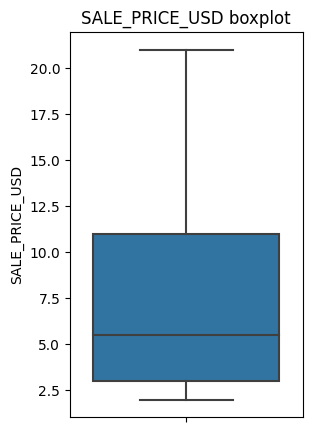

In [56]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['SALE_PRICE_USD'])
plt.title('SALE_PRICE_USD boxplot')
plt.show()

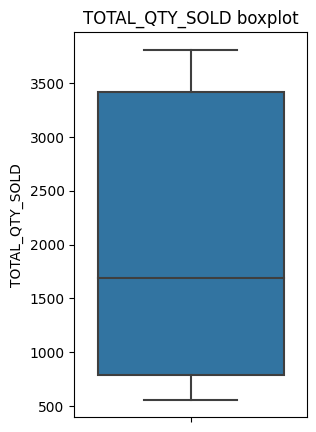

In [57]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_QTY_SOLD'])
plt.title('TOTAL_QTY_SOLD boxplot')
plt.show()

Based on the boxplot shown above, there are no outliers detected. Hence, no process required for this stage.

Note: Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of menu items, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# Train Test Split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_QTY_SOLD', axis=1), final_df['TOTAL_QTY_SOLD'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((70, 9), (30, 9))

# Categorical Variable Encoding 

In [59]:
# let's create the encoder

ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

In [60]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode

ohe_enc.fit(X_train)

c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consisten

OneHotEncoder(drop_last=True)

In [61]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [62]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Standard Scaler

In [63]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [64]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [65]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Model

In [66]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  329.1068276729115
the testing root mean squared error is:  310.2555739999605

the training mean squared error is:  108311.30402092748
the testing mean squared error is:  96258.52119804497

training accuracy is:  0.929290223851081
testing accuracy is:  0.9309793320665356


# Improve Model (GridSearch CV)

In [67]:
param_grid = {'n_estimators': [30, 40, 50, 60],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [5,6,7,8]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

print("Best parameters found: ", xgb_grid.best_params_)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best score found:  0.9544344788424208


# Improved Model Results

In [68]:
# Build XGBoost Model
xgb_improved = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 50)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  42.178504115228634
the testing root mean squared error is:  96.78125993894923

the training mean squared error is:  1779.026209398359
the testing mean squared error is:  9366.612275370459

training accuracy is:  0.9988385834131837
testing accuracy is:  0.9932838170847259


In [69]:
xgb_improved.feature_importances_

array([2.2411352e-01, 1.0336925e-03, 2.9461604e-04, 0.0000000e+00,
       0.0000000e+00, 2.4731809e-04, 1.4304767e-04, 5.4920191e-04,
       2.9109936e-04, 1.8945136e-04, 7.9853654e-02, 5.5535622e-02,
       7.4231130e-04, 2.7417609e-05, 4.9520722e-03, 3.6244333e-04,
       3.4912136e-05, 3.7400696e-05, 1.3106753e-04, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 5.3072250e-03, 6.2615389e-01, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [70]:
# Get the feature importances
feature_importance = xgb_improved.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                                  Feature  Importance
34                 ITEM_CATEGORY_Beverage    0.626154
0                          SALE_PRICE_USD    0.224114
10                        MENU_TYPE_Tacos    0.079854
11                          MENU_TYPE_BBQ    0.055536
33                     ITEM_CATEGORY_Main    0.005307
14                    MENU_TYPE_Ice Cream    0.004952
1                              DAIRY_FREE    0.001034
12                       MENU_TYPE_Crepes    0.000742
7                        MENU_TYPE_Indian    0.000549
15               MENU_TYPE_Grilled Cheese    0.000362
2                             GLUTEN_FREE    0.000295
8                      MENU_TYPE_Hot Dogs    0.000291
5                     MENU_TYPE_Ethiopian    0.000247
9                    MENU_TYPE_Vegetarian    0.000189
6                         MENU_TYPE_Gyros    0.000143
18                      MENU_TYPE_Chinese    0.000131
17                 MENU_TYPE_Mac & Cheese    0.000037
16                        ME